# 实验五-基于CNN实现一个人脸面部表情检测

在日常工作和生活中，人们情感的表达方式主要有：语言、声音、肢体行为（如手势）、以及面部表情等。在这些行为方式中，面部表情所携带的表达人类内心情感活动的信息最为丰富，据研究表明，人类的面部表情所携带的内心活动的信息在所有的上述的形式中比例最高，大约占比55%。

人类的面部表情变化可以传达出其内心的情绪变化，表情是人类内心世界的真实写照。上世纪70年代，美国著名心理学家保罗•艾克曼经过大量实验之后，将人类的基本表情定义为悲伤、害怕、厌恶、快乐、气愤和惊讶六种。同时，他们根据不同的面部表情类别建立了相应的表情图像数据库。随着研究的深入，中性表情也被研究学者加入基本面部表情中，组成了现今的人脸表情识别研究中的七种基础面部表情。


本次实验基于卷积神经网络模型开展表情识别的研究，为了尽可能的提高最终表情识别的准确性，需要大量的样本图片训练，优化，所以采用了 FER2013 数据集用来训练、测试，此数据集由 35886 张人脸表情图片组成，其中，测试图 28708 张，公共验证图和私有验证图各 3589 张，所有图片中共有7种表情。在预处理时把图像归一化为 48×48 像素，训练的网络结构是基于CNN网络结构

实验数据集来自于kaggle平台：https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
给定的数据集train.csv，我们要使用卷积神经网络CNN，根据每个样本的面部图片判断出其表情。在本项目中，表情共分7类，分别为：（0）生气，（1）厌恶，（2）恐惧，（3）高兴，（4）难过，（5）惊讶和（6）中立（即面无表情，无法归为前六类）。因此，项目实质上是一个7分类问题。
train.csv文件说明：

（1）CSV文件，大小为28710行X2305列；

（2）在28710行中，其中第一行为描述信息，即“emotion”和“pixels”两个单词，其余每行内含有一个样本信息，即共有28709个样本；

（3）在2305列中，其中第一列为该样本对应的emotion，取值范围为0到6。其余2304列为包含着每个样本大小为48X48人脸图片的像素值（2304=48X48），每个像素值取值范围在0到255之间；

## 数据集读取与预处理
原文件中，emotion和pixels人脸像素数据是集中在一起的。为了方便操作，决定利用pandas库进行数据分离，即将所有emotion读出后，写入新创建的文件emotion.csv；将所有的像素数据读出后，写入新创建的文件pixels.csv。

In [2]:
# 将emotion和pixels像素数据分离
import pandas as pd

# 注意修改train.csv为你电脑上文件所在的相对或绝对路劲地址。
path = './dataset/train.csv'
# 读取数据
df = pd.read_csv(path)
# 提取emotion数据
df_y = df[['emotion']]
# 提取pixels数据
df_x = df[['pixels']]
# 将emotion写入emotion.csv
df_y.to_csv('dataset/emotion.csv', index=False, header=False)
# 将pixels数据写入pixels.csv
df_x.to_csv('dataset/pixels.csv', index=False, header=False)

## 数据存储及可视化

In [4]:
import cv2
import numpy as np

# 指定存放图片的路径
path = './face_images'
# 读取像素数据
data = np.loadtxt('dataset/pixels.csv')

# 按行取数据
for i in range(data.shape[0]):
    face_array = data[i, :].reshape((48, 48)) # reshape
    # print(face_array)
    cv2.imwrite(path + '/' + '{}.jpg'.format(i), face_array) # 写图片

## 数据可视化
下面简单可视化几十张图片，看看数据集中的图片长什么样子。

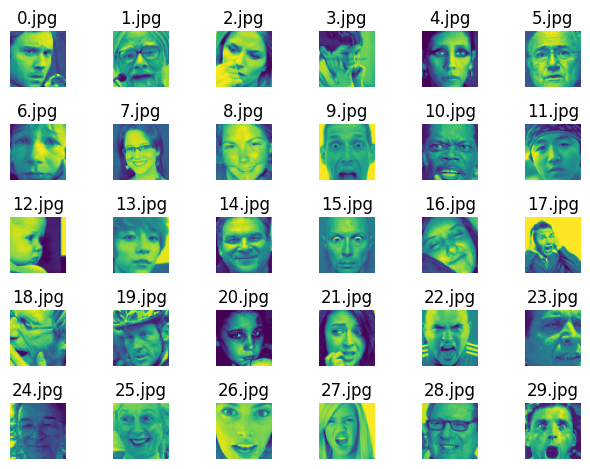

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt
for i in range(30):
    p_name = './face_images/{}.jpg'.format(i)   
    img = Image.open(p_name)
        # 创建子图，并显示图像
    plt.subplot(5, 6, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(p_name[14:])
plt.tight_layout()
plt.show()

建立映射创建image图片名和对应emotion表情数据集的映射关系表。

首先，我们需要划分一下训练集和验证集。在项目中，共有28709张图片，取前24000张图片作为训练集，其他图片作为验证集。新建文件夹train_set和verify_set，将0.jpg到23999.jpg放进文件夹train_set，将其他图片放进文件夹verify_set。

在继承torch.utils.data.Dataset类定制自己的数据集时，由于在数据加载过程中需要同时加载出一个样本的数据及其对应的emotion，因此最好能建立一个image的图片名和对应emotion表情数据的关系映射表，其中记录着image的图片名和其emotion表情数据的映射关系。

在实验中发现每张图片的命名不是都和emotion的存放顺序是一一对应的。在实际操作的过程中才发现，程序加载文件的机制是按照文件名首字母（或数字）来的，即加载次序是0，1，10，100......，而不是预想中的0，1，2，3......，因此加载出来的图片不能够和emotion[0]，emotion[1]，emotion[2]，emotion[3]......一一对应，所以建立image-emotion映射关系表还是相当有必要的。

建立image-emotion映射表的基本思路就是：指定文件夹（train_set或verify_set），遍历该文件夹下的所有文件，如果该文件是.jpg格式的图片，就将其图片名写入一个列表，同时通过图片名索引出其emotion，将其emotion写入另一个列表。最后利用pandas库将这两个列表写入同一个csv文件。

In [6]:
import os
def image_emotion_mapping(path):
    # 读取emotion文件
    df_emotion = pd.read_csv('dataset/emotion.csv', header = None)
    # 查看该文件夹下所有文件
    files_dir = os.listdir(path)
    # 用于存放图片名
    path_list = []
    # 用于存放图片对应的emotion
    emotion_list = []
    # 遍历该文件夹下的所有文件
    for file_dir in files_dir:
        # 如果某文件是图片，则将其文件名以及对应的emotion取出，分别放入path_list和emotion_list这两个列表中
        if os.path.splitext(file_dir)[1] == ".jpg":
            path_list.append(file_dir)
            index = int(os.path.splitext(file_dir)[0])
            emotion_list.append(df_emotion.iat[index, 0])

    # 将两个列表写进image_emotion.csv文件
    path_s = pd.Series(path_list)
    emotion_s = pd.Series(emotion_list)
    df = pd.DataFrame()
    df['path'] = path_s
    df['emotion'] = emotion_s
    df.to_csv(path+'\\image_emotion.csv', index=False, header=False)

train_set_path = 'face_images/train_set'
verify_set_path = 'face_images/verify_set'
image_emotion_mapping(train_set_path)
image_emotion_mapping(verify_set_path)

简单查看一下生成的映射文件

In [7]:
df_mapping = pd.read_csv('face_images/train_set/image_emotion.csv', header=None)
df_mapping[:10]

,0,1
0,0.jpg,0
1,1.jpg,0
2,10.jpg,0
3,100.jpg,3
4,1000.jpg,6
5,10000.jpg,3
6,10001.jpg,3
7,10002.jpg,0
8,10003.jpg,6
9,10004.jpg,4


发现图片和对应的label已经建立了映射,这个映射文件就是帮助我们在后续的数据加载过程中，能够通过图片名索引出其对应的emotion。

用opencv将所有图片读取出来，最简单粗暴的方法就是直接以numpy中array的数据格式直接送给模型。如果这样做的话，会一次性把所有图片全部读入内存，占用大量的内存空间，且只能使用单线程，效率不高，也不方便后续操作。

在pytorch中，有一个类（torch.utils.data.Dataset）是专门用来加载数据的，我们可以通过继承这个类来定制自己的数据集和加载方法。
Dataset类是Pytorch中图像数据集中最为重要的一个类，也是Pytorch中所有数据集加载类中应该继承的父类。其中父类中的两个私有成员函数必须被重载，否则将会触发错误提示：

def getitem(self, index):

def len(self):

其中__len__应该返回数据集的大小，而__getitem__应该编写支持数据集索引的函数，例如通过dataset[i]可以得到数据集中的第i+1个数据。

In [8]:

import torch
from torch.utils import data
import numpy as np
import pandas as pd
import cv2

# 我们通过继承Dataset类来创建我们自己的数据加载类，命名为FaceDataset
class FaceDataset(data.Dataset):
    '''
    首先要做的是类的初始化。之前的image-emotion对照表已经创建完毕，
    在加载数据时需用到其中的信息。因此在初始化过程中，我们需要完成对image-emotion对照表中数据的读取工作。
    通过pandas库读取数据，随后将读取到的数据放入list或numpy中，方便后期索引。
    '''
    # 初始化
    def __init__(self, root):
        super(FaceDataset, self).__init__()
        self.root = root
        df_path = pd.read_csv(root + '\\image_emotion.csv', header=None, usecols=[0])
        df_label = pd.read_csv(root + '\\image_emotion.csv', header=None, usecols=[1])
        self.path = np.array(df_path)[:, 0]
        self.label = np.array(df_label)[:, 0]

    '''
    接着就要重写getitem()函数了，该函数的功能是加载数据。
    在前面的初始化部分，我们已经获取了所有图片的地址，在这个函数中，我们就要通过地址来读取数据。
    由于是读取图片数据，因此仍然借助opencv库。
    需要注意的是，之前可视化数据部分将像素值恢复为人脸图片并保存，得到的是3通道的灰色图（每个通道都完全一样），
    而在这里我们只需要用到单通道，因此在图片读取过程中，即使原图本来就是灰色的，但我们还是要加入参数从cv2.COLOR_BGR2GARY，
    保证读出来的数据是单通道的。读取出来之后，可以考虑进行一些基本的图像处理操作，如通过高斯模糊降噪、通过直方图均衡化来增强图像等。
    读出的数据是48X48的，而后续卷积神经网络中nn.Conv2d() API所接受的数据格式是(batch_size, channel, width, higth)，
    本次图片通道为1，因此我们要将48X48 reshape为1X48X48。
    '''

    # 读取某幅图片，item为索引号
    def __getitem__(self, item):
        face = cv2.imread(self.root + '\\' + self.path[item])
        # 读取单通道灰度图
        face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        # 高斯模糊
        # face_Gus = cv2.GaussianBlur(face_gray, (3,3), 0)
        # 直方图均衡化
        face_hist = cv2.equalizeHist(face_gray)
        # 像素值标准化
        face_normalized = face_hist.reshape(1, 48, 48) / 255.0 # 为与pytorch中卷积神经网络API的设计相适配，需reshape原图
        # 用于训练的数据需为tensor类型
        face_tensor = torch.from_numpy(face_normalized) # 将python中的numpy数据类型转化为pytorch中的tensor数据类型
        face_tensor = face_tensor.type('torch.FloatTensor') # 指定为'torch.FloatTensor'型，否则送进模型后会因数据类型不匹配而报错
        label = self.label[item]
        return face_tensor, label


    '''
    最后就是重写len()函数获取数据集大小了。
    self.path中存储着所有的图片名，获取self.path第一维的大小，即为数据集的大小。
    '''
    # 获取数据集样本个数
    def __len__(self):
        return self.path.shape[0]

## 模型训练部分
定义我们设计模型的结构，定义神经网络

In [11]:
import torch.nn as nn
from torch import optim
# 参数初始化
def gaussian_weights_init(m):
    classname = m.__class__.__name__
    # 字符串查找find，找不到返回-1，不等-1即字符串中含有该字符
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.04)
# 验证模型在验证集上的正确率
def validate(model, dataset, batch_size):
    val_loader = data.DataLoader(dataset, batch_size)
    result, num = 0.0, 0
    for images, labels in val_loader:
        pred = model.forward(images)
        pred = np.argmax(pred.data.numpy(), axis=1)
        labels = labels.data.numpy()
        result += np.sum((pred == labels))
        num += len(images)
    acc = result / num
    return acc

class FaceCNN(nn.Module):
    # 初始化网络结构
    def __init__(self):
        super(FaceCNN, self).__init__()
        # 第一次卷积、池化
        self.conv1 = nn.Sequential(
            # 输入通道数in_channels，输出通道数(即卷积核的通道数)out_channels，卷积核大小kernel_size，步长stride，对称填0行列数padding
            # input:(bitch_size, 1, 48, 48), output:(bitch_size, 64, 48, 48), (48-3+2*1)/1+1 = 48
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1), # 卷积层
            nn.BatchNorm2d(num_features=64), # 归一化
            nn.RReLU(inplace=True), # 激活函数
            # output(bitch_size, 64, 24, 24)
            nn.MaxPool2d(kernel_size=2, stride=2), # 最大值池化
        )
        # 第二次卷积、池化
        self.conv2 = nn.Sequential(
            # input:(bitch_size, 64, 24, 24), output:(bitch_size, 128, 24, 24), (24-3+2*1)/1+1 = 24
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.RReLU(inplace=True),
            # output:(bitch_size, 128, 12 ,12)
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # 第三次卷积、池化
        self.conv3 = nn.Sequential(
            # input:(bitch_size, 128, 12, 12), output:(bitch_size, 256, 12, 12), (12-3+2*1)/1+1 = 12
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.RReLU(inplace=True),
            # output:(bitch_size, 256, 6 ,6)
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # 参数初始化
        self.conv1.apply(gaussian_weights_init)
        self.conv2.apply(gaussian_weights_init)
        self.conv3.apply(gaussian_weights_init)
        # 全连接层
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256*6*6, out_features=4096),
            nn.RReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=1024),
            nn.RReLU(inplace=True),
            nn.Linear(in_features=1024, out_features=256),
            nn.RReLU(inplace=True),
            nn.Linear(in_features=256, out_features=7),
        )
    # 前向传播
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # 数据扁平化
        x = x.view(x.shape[0], -1)
        y = self.fc(x)
        return y
    

模型训练函数设计

In [12]:
def train(train_dataset, val_dataset, batch_size, epochs, learning_rate, wt_decay):
    # 载入数据并分割batch
    train_loader = data.DataLoader(train_dataset, batch_size)
    # 构建模型
    model = FaceCNN()
    # 损失函数
    loss_function = nn.CrossEntropyLoss()
    # 优化器
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=wt_decay)
    # 学习率衰减
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
    # 逐轮训练
    for epoch in range(epochs):
        # 记录损失值
        loss_rate = 0
        # scheduler.step() # 学习率衰减
        model.train() # 模型训练
        for images, emotion in train_loader:
            # 梯度清零
            optimizer.zero_grad()
            # 前向传播
            output = model.forward(images)
            # 误差计算
            loss_rate = loss_function(output, emotion)
            # 误差的反向传播
            loss_rate.backward()
            # 更新参数
            optimizer.step()
        # 打印每轮的损失
        print('After {} epochs , the loss_rate is : '.format(epoch+1), loss_rate.item())
        if epoch % 5 == 0:
            model.eval() # 模型评估
            acc_train = validate(model, train_dataset, batch_size)
            acc_val = validate(model, val_dataset, batch_size)
            print('After {} epochs , the acc_train is : '.format(epoch+1), acc_train)
            print('After {} epochs , the acc_val is : '.format(epoch+1), acc_val)
    return model

## 模型训练
传入我们的数据集，分为训练集和验证集，进行训练。

In [13]:
train_dataset = FaceDataset(root='face_images/train_set')
val_dataset = FaceDataset(root='face_images/verify_set')
# 超参数可自行指定
model = train(train_dataset, val_dataset, batch_size=128, epochs=20, learning_rate=0.1, wt_decay=0)
# 保存模型
torch.save(model, 'model_cnn.pkl')

After 1 epochs , the loss_rate is :  1.7288906574249268
After 1 epochs , the acc_train is :  0.15383333333333332
After 1 epochs , the acc_val is :  0.16075599915056274
After 2 epochs , the loss_rate is :  1.4142237901687622
After 3 epochs , the loss_rate is :  1.2723634243011475
After 4 epochs , the loss_rate is :  1.1360224485397339
After 5 epochs , the loss_rate is :  1.0398962497711182
After 6 epochs , the loss_rate is :  0.949511706829071
After 6 epochs , the acc_train is :  0.48954166666666665
After 6 epochs , the acc_val is :  0.4839668719473349
After 7 epochs , the loss_rate is :  0.924917995929718
After 8 epochs , the loss_rate is :  0.8466352224349976
After 9 epochs , the loss_rate is :  0.867508590221405
After 10 epochs , the loss_rate is :  0.7095733284950256
After 11 epochs , the loss_rate is :  0.6661862730979919
After 11 epochs , the acc_train is :  0.582
After 11 epochs , the acc_val is :  0.5294117647058824
After 12 epochs , the loss_rate is :  0.6911014318466187
After 

查看模型结构

In [14]:
model

FaceCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, pa

## 模型效果测试
这里可以直接读取训练好的权重文件，直接进行测试。
如果重启内核后读入，需要再定义一下模型结构，也就是重新运行一模型结构那部分代码

In [43]:
# 加载人脸检测模型
face_detection = cv2.CascadeClassifier('model/haarcascade_frontalface_default.xml')
# 加载表情识别模型
emotion_classifier = torch.load('./model/model_cnn.pkl')
# 表情标签
emotion_labels = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
# 人脸数据归一化，将像素值从0-255映射到0-1之间
def preprocess_input(face):
    face = face / 255.0
    return face
def predict_emotion(input_image_path):
    # 加载图像
    frame = cv2.imread(input_image_path)
    # 转换为灰度图像
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # 检测图像中的人脸
    faces = face_detection.detectMultiScale(gray, 1.3, 5)
    # 处理每个检测到的人脸
    for (x, y, w, h) in faces:
        # 在人脸周围画一个矩形框
        cv2.rectangle(frame, (x, y), (x+w, y+h), (84, 255, 159), 2)
        # 获取灰度人脸图像
        face = gray[y:y+h, x:x+w]
        # 将人脸调整为48x48像素
        face = cv2.resize(face, (48, 48))
        # 扩展维度以匹配模型的输入形状
        face = np.expand_dims(face, 0)
        face = np.expand_dims(face, 0)
        # 归一化人脸图像
        face = preprocess_input(face)
        new_face = torch.from_numpy(face)
        new_new_face = new_face.float().requires_grad_(False)
        # 预测表情
        emotion_arg = np.argmax(emotion_classifier.forward(new_new_face).detach().numpy())
        emotion = emotion_labels[emotion_arg]as`
        # 在图像上显示预测的表情
        cv2.putText(frame, emotion, (x, y-30), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4)
    return frame
def batch_pred(input_floder,output_floder):
    # 读取文件夹下所有图片
    files_dirs = os.listdir(input_floder)
    # 遍历该文件夹下的所有文件
    for image in files_dirs:
        # 如果某文件是图片，则将其文件名以及对应的emotion取出，分别放入path_list和emotion_list这两个列表中
        input_image_path = input_floder + '/' + image
        
        frame= predict_emotion(input_image_path)
        output_image_path = output_floder + '/' + image
        cv2.imwrite(output_image_path, frame)
    

E:\Anaconda\envs\deepl\lib\site-packages\torch\serialization.py:622: UserWarning: Couldn't retrieve source code for container of type FaceCNN. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
E:\Anaconda\envs\deepl\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
E:\Anaconda\envs\deepl\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceC

上一段代码通过预选练的人脸检测模型，对测试图片中的人脸进行检测和处理。
同时定义了一个字典，将预测向量和实际结果进行对应，用方框标记出人脸，并在方框上方标注出预测的表情。



## 展示模型输出结果

### 分辨一些身边的朋友的表情


In [93]:
images_test_path = './test/input2'
batch_pred(images_test_path,'test/output')

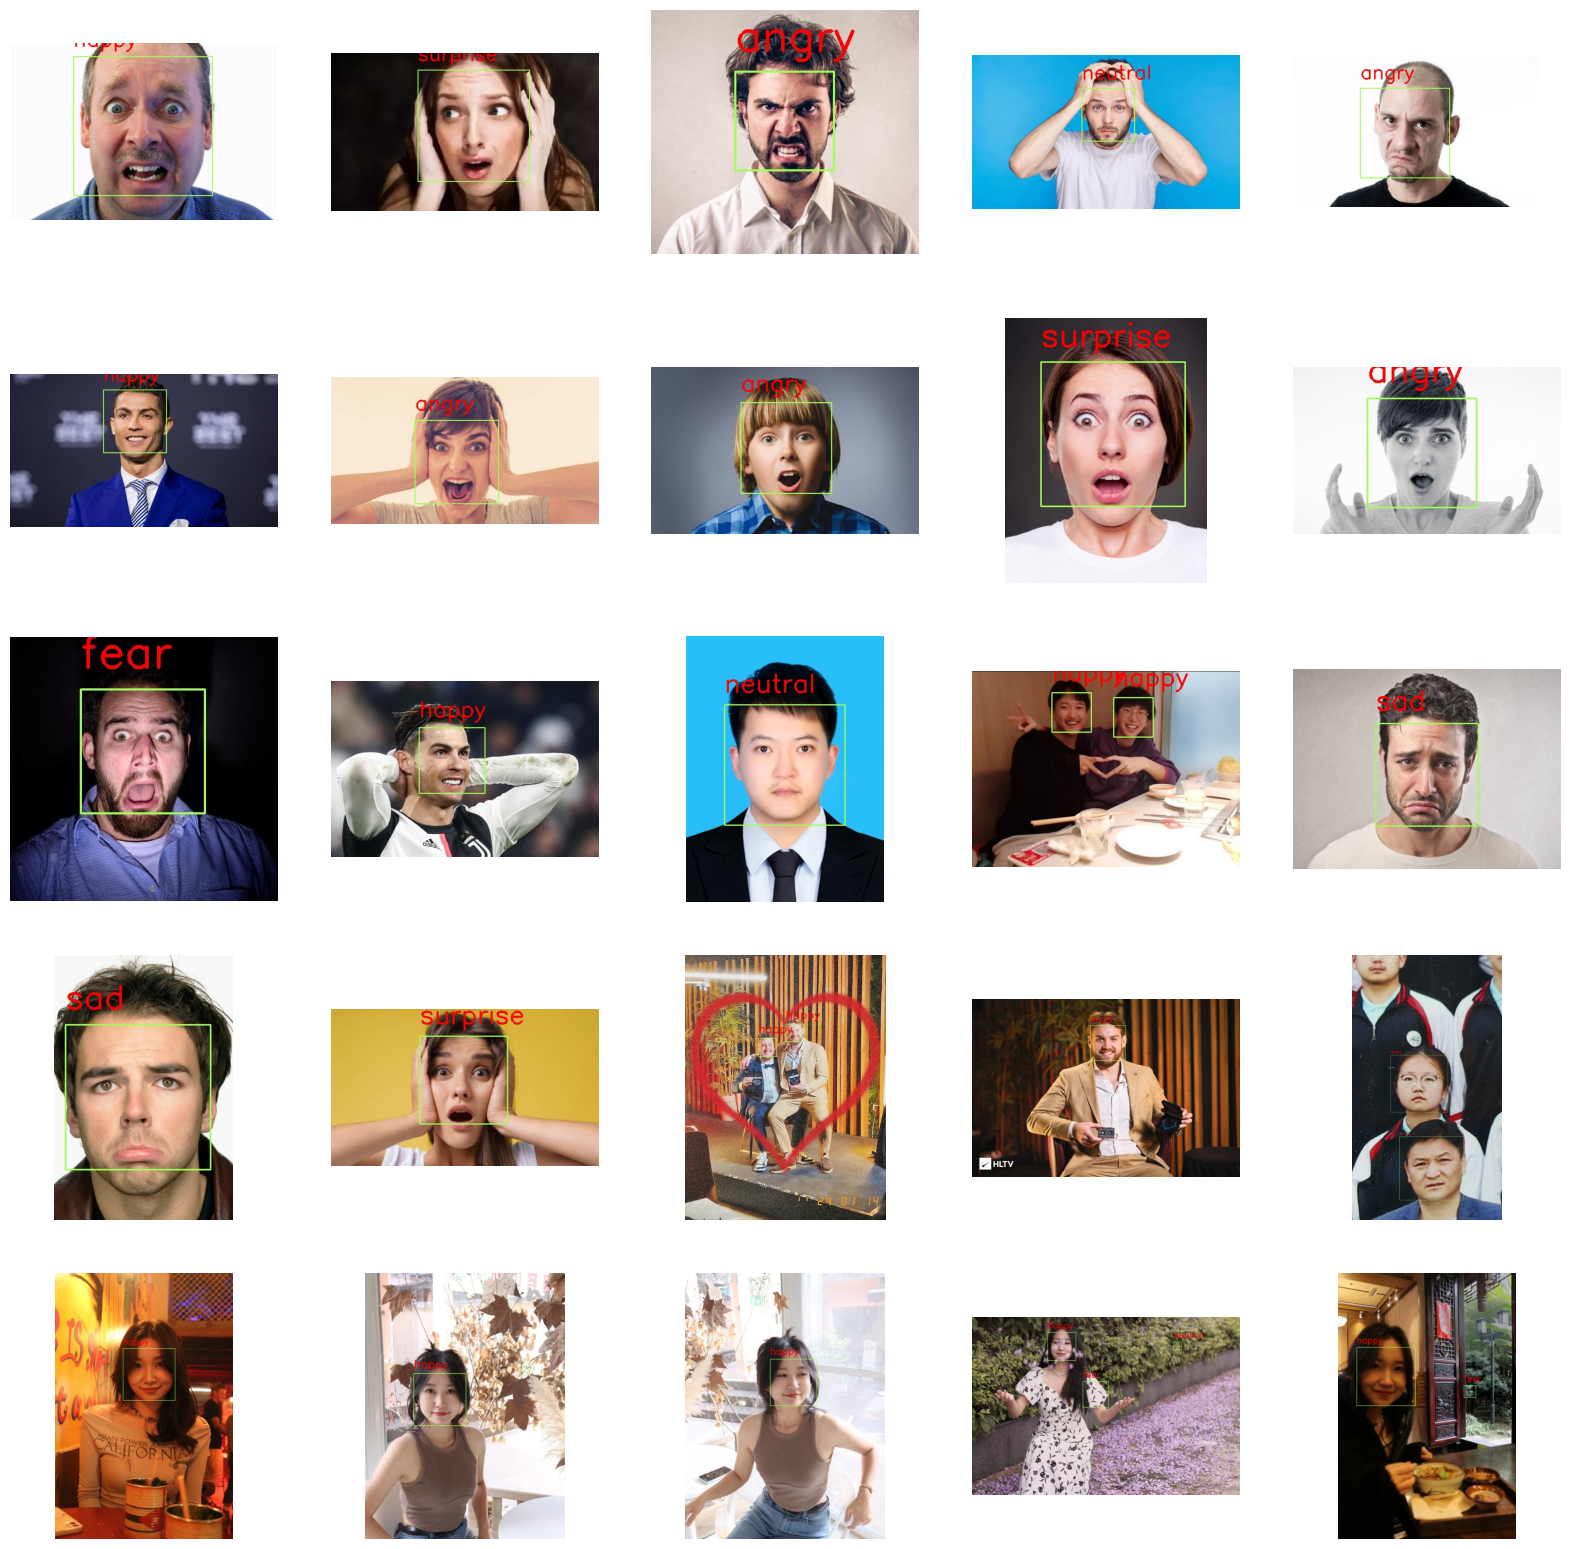

In [100]:
import matplotlib.image as mpimg

file_path = './test/output'
files_dir = os.listdir(file_path)
pos = 1
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for file_name in files_dir:
    image_name = file_path + '/' + file_name
    img = mpimg.imread(image_name)
    axs[int((pos-1)/5)][(pos-1)%5].imshow(img)
    axs[int((pos-1)/5)][(pos-1)%5].axis('off')
    pos+=1

我们可以看到，成功的选中了人脸和表情，并成功标记图中的人脸。不管是多人合照还是单人写真都可以很好地实现表情识别。
但是在一些图片中，会把一些风景识别为人脸，后续可以继续改进。

(-0.5, 1279.5, 1919.5, -0.5)

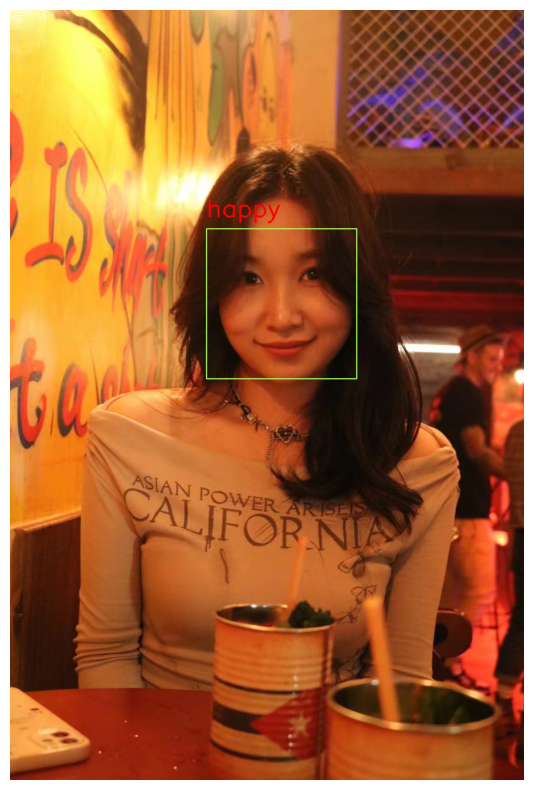

In [101]:
# 高清展示一张图
image_name = './test/output/test_yh.jpg'
img = mpimg.imread(image_name)
# 放大一些
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')


### 实验总结
本次实验基于pytorch和卷积神经网络实现一个人脸表情检测模型，实验目的为通过训练好的模型来检测同中出现的多张人脸，并依次判别人脸的表情标签。实验数据集采用来开源FER数据集，有近三万张照片。划分训练集和测试集进行训练。
实验不足：实验中数据集过大，实现训练的时候时间耗费过多，无法训练过大的epoch，同时无法及时调参，只能更具经验选择一些较优的超参数设置。从测试结果中可以看到模型基本可以分辨出图片中的表情。但是恐惧fear和angry或者是surprise类的表情模型无法实现很好的界定，这是因为我们训练时候模型的验证效果达到最好。因为训练太过费力只能训练轮来当作baseline进行测试。同时我们选用的人脸检测模型也是预训练的一些模型，在一些风景照中，会把一些风景识别为人脸，后续可以继续改进。